In [1]:
# from Bio import Entrez
# from Bio import SeqIO
import os
import warnings

import numpy as np
import pandas as pd
import requests
import shap
import statsmodels.api as sm
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import tree
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
prefix = "https://rfbr-18-29-13027.sysbio.cytogen.ru/"


# Entrez.email = "a.zozulya@g.nsu.ru"


def get_dataframe(url):
    result = requests.get(url=prefix + url, verify=False)
    result_json = result.json()
    return pd.json_normalize(result_json)


def update_to_nan(df):
    return df.apply(lambda x: str(x).strip()).replace('', np.nan)

# def get_gene_id(gene_name):
#     query = f"{gene_name} [GENE];Homo sapiens[ORGN]"
#     search_result = Entrez.esearch(db="gene", retmax=1, term=query)
#     result_dict = Entrez.read(search_result)
#     search_result.close()
#     search_result_count = int(result_dict['Count'])
#     # if search_result_count != 1:
#     #     raise ValueError(f"search count is more then 1: {search_result_count}")
#     return result_dict['IdList'][0]

In [2]:
target_snps = pd.read_csv("./select_snp_id_count_snp_id_as_.csv")
target_humans = pd.read_csv("./Result_63.csv")
all_mutations = pd.read_csv("./icbrain_brain_human_mutations.csv")
# последняя версия 3
data_frame = pd.read_csv("./data_frame_with_mutations_one_hot.csv")
result_df = pd.read_csv("./data_frame_with_mutations_one_hot_3.csv")
result_df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
data_frame.drop(columns=['Unnamed: 0'], inplace=True)
data_frame = data_frame.dropna()
data_frame = data_frame.drop(data_frame[data_frame['is_depressed'] == True].index)

In [20]:
def create_test_samples(df):
    test_samples = df.sample(n=500, random_state=100)
    smote = SMOTE(random_state=42)
    return smote.fit_resample(test_samples.drop(columns='is_depressed'), test_samples.is_depressed.astype(bool))


def cross_val(model, X, y, metric='roc_auc'):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return mean(scores)


def balance_classes(df):
    depressed = df[df['is_depressed'] == True]
    not_depressed = df[df['is_depressed'] == False].sample(n=depressed.shape[0], random_state=42)
    return pd.concat([depressed, not_depressed])


def exclude_with_variance_threshold(data):
    selector = VarianceThreshold(threshold=0.1)
    selector.fit(data)
    return selector


def get_high_correlated(data):
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return [column for column in upper.columns if any(upper[column] > 0.95)]


def split_train_test(X_data, y_data):
    return train_test_split(X_data, y_data, test_size=0.25, random_state=0)


def min_max_normalization(df):
    return (df - df.min()) / (df.max() - df.min())


def get_x_y(data):
    return data.drop(columns=['is_depressed']), data.is_depressed.astype(bool)


def draw_confusion_matrix(model, X_test, y_test):
    fig, axs = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, ax=axs, colorbar=False
    )

    fig.tight_layout()


def draw_tree(random_forest, tree_number, feature_names):
    plt.figure(figsize=(20, 10))
    tree.plot_tree(random_forest.estimators_[tree_number], filled=True,  feature_names=feature_names)
    plt.show()


def show_explainer_shap_importance(model, X_test, X_train):
    f = lambda x: model.predict_proba(x)[:, 1]
    explainer = shap.PermutationExplainer(f, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])
    return compute_feature_importance(shap_values, X_test.columns)


def show_kernel_explainer_shap_importance(model, X_test, X_train):
    f = lambda x: model.predict_proba(x)[:, 1]
    med = X_train.sample(200)
    explainer = shap.KernelExplainer(f, med)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])
    return compute_feature_importance(shap_values, X_test.columns)


def show_explainer_shap_importance_1(model, X_test, X_train):
    f = lambda x: model.predict_proba(x)[:, 1]
    explainer = shap.Explainer(model=f, masker=X_train, algorithm='tree')
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])
    return compute_feature_importance(shap_values, X_test.columns)


def compute_feature_importance(shap_values, feature_names):
    rf_resultX = pd.DataFrame(shap_values, columns=feature_names)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                   columns=['col_name', 'feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False, inplace=True)

    return shap_importance


def show_tree_shap_importance(model, X_test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[1], X_test, max_display=X_test.shape[1])
    return compute_feature_importance(shap_values[1], X_test.columns)


def show_roc_auc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [4]:
full_human_data = pd.read_csv("full_human_data.csv")
# уберем национальности, потому что большой разброс
full_human_data.drop(columns='nationality', inplace=True)
full_human_data.sex -= 1
full_human_data

,age,sex,r_city,ethnos,is_depressed,is_rs6318,is_rs5569,is_2919,is_15377,is_9698,is_12845,is_11366,is_16987,is_12170,is_rs4680,is_rs6265
0,29,1,Хандыга,mon,False,False,False,True,False,True,False,False,False,False,True,False
1,41,1,Хандыга,mon,False,False,False,True,False,True,False,False,False,False,True,False
2,37,1,Хандыга,mon,False,False,False,False,False,True,False,False,False,False,True,False
3,23,0,Хандыга,mon,False,False,False,True,False,True,False,False,False,False,True,False
4,18,0,Хандыга,mon,False,False,False,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,19,0,Якутск,mon,False,False,False,False,False,False,False,False,False,False,True,False
891,18,0,Якутск,mon,False,False,False,False,False,False,False,False,False,False,True,False
892,19,0,Якутск,evr,False,False,False,False,False,False,False,False,False,False,True,False
893,28,0,Якутск,evr,False,False,False,False,False,False,False,False,False,False,True,False


In [5]:
full_human_data = pd.get_dummies(full_human_data).astype(float)
full_human_data.age = min_max_normalization(full_human_data.age)
full_human_data
# убрать негроида

,age,sex,is_depressed,is_rs6318,is_rs5569,is_2919,is_15377,is_9698,is_12845,is_11366,...,is_rs6265,r_city_Байкал_медитатор,r_city_Болотное,r_city_Кызыл,r_city_Новосибирск,r_city_Хандыга,r_city_Якутск,ethnos_evr,ethnos_mon,ethnos_negr
0,0.242857,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.414286,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.357143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.157143,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.085714,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
891,0.085714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
892,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
893,0.228571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [5]:
result_df

,16212,1967,11837,10591,450,10871,17446,4153,1936,15270,...,11824,3217,14469,4331,3862,17869,14005,12370,17268,is_depressed
0,True,True,True,True,True,True,True,True,True,True,...,False,True,True,False,False,True,True,True,True,False
1,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,False,True,True,True,True,False
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
3,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,False
4,True,True,True,True,True,True,True,True,True,True,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,True,True,True,True,True,True,True,True,True,True,...,True,False,True,False,True,True,True,True,True,True
929,True,True,True,True,True,True,True,True,True,True,...,True,True,False,True,True,False,False,False,False,True
930,True,True,True,True,True,True,True,True,True,True,...,False,False,False,True,True,False,False,False,False,True
931,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True


In [6]:

fd_test_samples, fd_y_test_samples = create_test_samples(full_human_data)

In [7]:
fd_result_df_balanced = balance_classes(full_human_data)

In [8]:
X_data_fd, y_data_fd = get_x_y(fd_result_df_balanced)

In [9]:
X_train_fd, X_test_fd, y_train_fd, y_test_fd = split_train_test(X_data_fd, y_data_fd)

In [46]:
from sklearn.feature_selection import mutual_info_classif

MI_score = mutual_info_classif(X_train_fd, y_train_fd, random_state=0)
for feature in zip(X_train_fd.columns, MI_score):
    print(feature)

('age', 0.12131377484788963)
('sex', 0.0)
('is_rs6318', 0.023967544689159404)
('is_rs5569', 0.0)
('is_2919', 0.05694253028363039)
('is_15377', 0.034564586536201425)
('is_9698', 0.0)
('is_12845', 0.08814035104946583)
('is_11366', 0.04709915844577317)
('is_16987', 0.14466603023139513)
('is_12170', 0.016124577471192225)
('is_rs4680', 0.0)
('is_rs6265', 0.0)
('r_city_Байкал_медитатор', 0.0)
('r_city_Болотное', 0.0)
('r_city_Кызыл', 0.09954699995611471)
('r_city_Новосибирск', 0.1683954547420694)
('r_city_Хандыга', 0.06568381453042904)
('r_city_Якутск', 0.10416836238997718)
('ethnos_evr', 0.08974187452598925)
('ethnos_mon', 0.015955880427495295)
('ethnos_negr', 0.0)


In [47]:
logit_model_fd = sm.Logit(y_train_fd, X_train_fd)
logit_resul_fd = logit_model_fd.fit()
print(logit_resul_fd.summary2())

         Current function value: 0.230660
         Iterations: 35


LinAlgError: Singular matrix

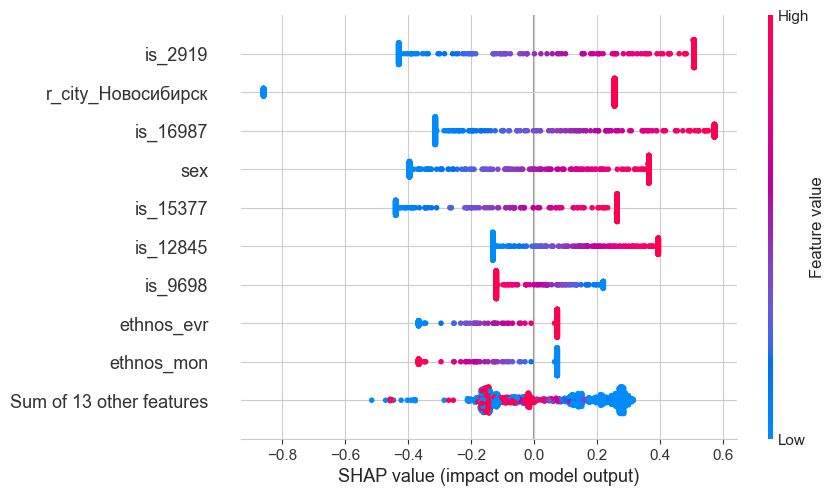

In [48]:
logreg_fd = LogisticRegression()
logreg_fd.fit(X_train_fd, y_train_fd)
explainer = shap.Explainer(
    logreg_fd, X_train_fd
)
shap_values = explainer(fd_test_samples[X_train_fd.columns])
shap.plots.beeswarm(shap_values)

In [49]:
y_pred_fd = logreg_fd.predict(fd_test_samples)
print(classification_report(fd_y_test_samples, y_pred_fd))

              precision    recall  f1-score   support

       False       0.92      0.75      0.82       477
        True       0.79      0.94      0.85       477

    accuracy                           0.84       954
   macro avg       0.85      0.84      0.84       954
weighted avg       0.85      0.84      0.84       954



In [14]:
logit_model_fd = sm.Logit(y_train_fd, X_train_fd)
logit_resul_fd = logit_model_fd.fit()
print(logit_resul_fd.summary2())

         Current function value: 0.339272
         Iterations: 35
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.407     
Dependent Variable:    is_depressed        AIC:                 81.6762   
Date:                  2023-11-28 01:08    BIC:                 110.9880  
No. Observations:      85                  Log-Likelihood:      -28.838   
Df Model:              11                  LL-Null:             -48.605   
Df Residuals:          73                  LLR p-value:         4.2975e-05
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
             Coef.     Std.Err.     z    P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
age          -5.1470      3.3359 -1.5429 0.1229      -11.6852   

Maximum Likelihood optimization failed to converge. Check mle_retvals


In [5]:
result_df = result_df.astype(float)
test_samples, y_test_samples = create_test_samples(result_df)

In [6]:
result_df_balanced = balance_classes(result_df)

In [6]:
# X_data, y_data = get_x_y(result_df_balanced)
X_data, y_data = get_x_y(result_df)

In [7]:
selector = exclude_with_variance_threshold(X_data)
after_variance_threshhold_deleted_columns = X_data.drop(
    columns=X_data.columns[selector.get_support(indices=True)]).columns
X_data = X_data[X_data.columns[selector.get_support(indices=True)]]
print(after_variance_threshhold_deleted_columns)

Index(['16212', '1967', '10591', '450', '10871', '17446', '4153', '1936',
       '1676', '15222', '14481', '3643', '1558', '10713', '1078', '5813',
       '2572'],
      dtype='object')


In [8]:
X_train, X_test, y_train, y_test = split_train_test(X_data, y_data)

In [68]:

class_weights = ['balanced', 'balanced_subsample']
criterions = ["gini", "entropy"]
min_samples_leaf_range = np.arange(5, 15, 1)
n_estimators_range = [10, 100, 1000]
param_grid = dict(n_estimators=n_estimators_range, min_samples_leaf=min_samples_leaf_range, class_weight=class_weights,
                  criterion=criterions)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv, scoring='recall')
grid.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [10, 100, 1000]},
             scoring='recall')

In [69]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_leaf': 14, 'n_estimators': 1000} with a score of 0.82


In [9]:
random_forest_2 = RandomForestClassifier(
    min_samples_leaf=17,
    class_weight='balanced_subsample',
    n_estimators=2000,
    criterion='gini')
random_forest_2.fit(X_train, y_train)
random_forest_preds_2 = random_forest_2.predict(test_samples[X_train.columns])

y_pred = random_forest_2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.74      0.84       214
        True       0.22      0.80      0.35        20

    accuracy                           0.74       234
   macro avg       0.60      0.77      0.59       234
weighted avg       0.91      0.74      0.80       234



In [11]:
y_test.value_counts()

pydev debugger: Unable to find real location for: C:\Users\Artem\AppData\Local\Temp\ipykernel_14968\1370389774.py


is_depressed
False    214
True      20
Name: count, dtype: int64

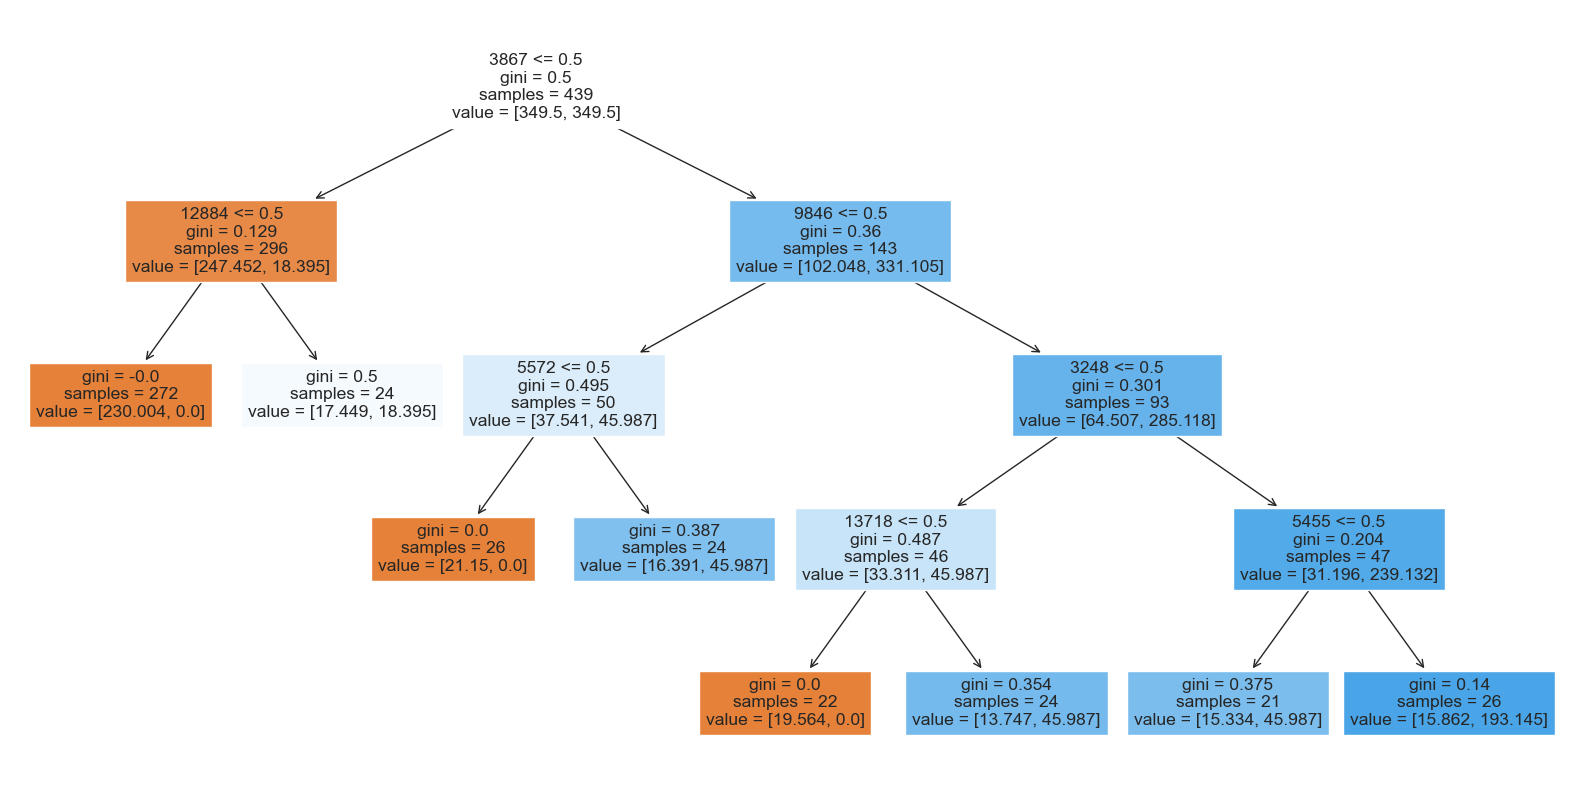

In [28]:
draw_tree(random_forest_2, 9, X_train.columns)

In [43]:
pd.concat([X_test, y_test], axis=1)[['3867', '11569']]

,3867,11569
689,0.0,0.0
236,0.0,0.0
737,1.0,1.0
765,1.0,1.0
266,0.0,0.0
...,...,...
735,1.0,1.0
172,0.0,0.0
492,0.0,0.0
803,0.0,0.0


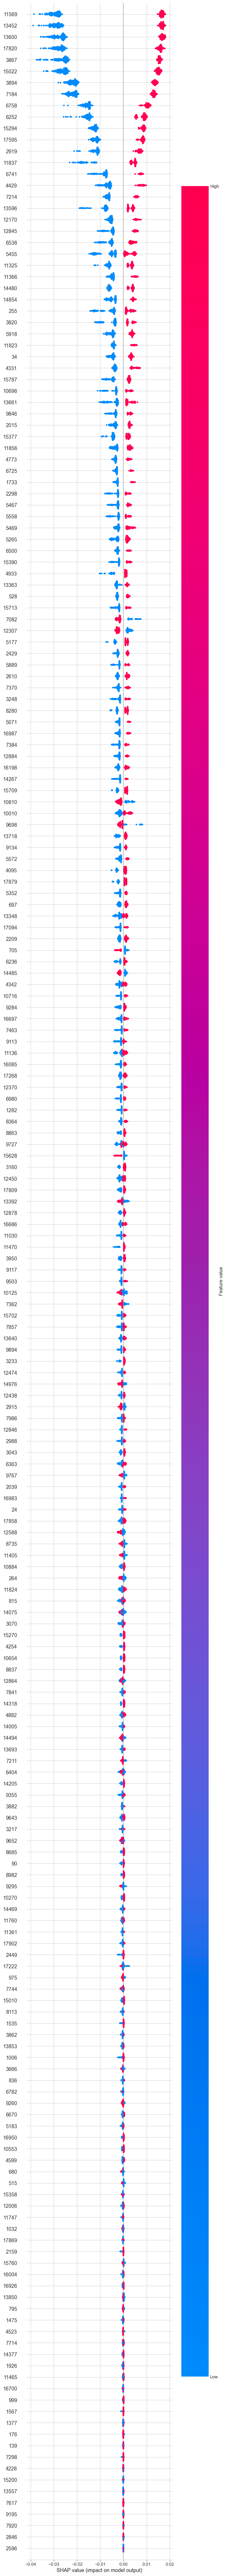

In [14]:
random_forest_shap = show_tree_shap_importance(random_forest_2, X_test)

In [9]:


class_weights = ['balanced', 'balanced_subsample']
criterions = ["gini", "entropy"]
min_samples_leaf_range = np.arange(5, 17, 1)
n_estimators_range = [10, 100, 500, 1000]
replacements = [True, False]
warm_starts = [True, False]
max_features = ["sqrt", "log2"]
param_grid = dict(n_estimators=n_estimators_range, min_samples_leaf=min_samples_leaf_range, class_weight=class_weights,
                  criterion=criterions, warm_start=warm_starts, replacement=replacements, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(BalancedRandomForestClassifier(sampling_strategy='not minority', n_jobs=-1), param_grid=param_grid,
                    cv=cv, scoring='recall')
grid.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 13, 'n_estimators': 500, 'replacement': True, 'warm_start': True} with a score of 1.00


InvalidParameterError: The 'n_estimators' parameter of BalancedRandomForestClassifier must be an int in the range [1, inf). Got {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 13, 'n_estimators': 500, 'replacement': True, 'warm_start': True} instead.

In [24]:
balanced_random_forest = BalancedRandomForestClassifier(class_weight='balanced', criterion='gini', max_features='sqrt',
                                                        min_samples_leaf=13, n_estimators=500, replacement=True,
                                                        warm_start=True)
balanced_random_forest.fit(X_train, y_train)

y_pred = balanced_random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       214
        True       0.09      1.00      0.16        20

    accuracy                           0.09       234
   macro avg       0.04      0.50      0.08       234
weighted avg       0.01      0.09      0.01       234



In [47]:
estimators = [LogisticRegression(), AdaBoostClassifier(), DecisionTreeClassifier()]
replacements = [True, False]
n_estimators_range = [10, 100, 500, 1000]
warm_starts = [True, False]
param_grid = dict(n_estimators=n_estimators_range, replacement=replacements, estimator=estimators,
                  warm_start=warm_starts)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(EasyEnsembleClassifier(sampling_strategy='not minority'), param_grid=param_grid, cv=cv,
                    scoring='recall')
grid.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'estimator': AdaBoostClassifier(), 'n_estimators': 100, 'replacement': False, 'warm_start': True} with a score of 0.94


InvalidParameterError: The 'n_estimators' parameter of EasyEnsembleClassifier must be an int in the range [1, inf). Got {'estimator': AdaBoostClassifier(), 'n_estimators': 100, 'replacement': False, 'warm_start': True} instead.

              precision    recall  f1-score   support

       False       0.99      0.70      0.82       214
        True       0.23      0.95      0.37        20

    accuracy                           0.72       234
   macro avg       0.61      0.83      0.60       234
weighted avg       0.93      0.72      0.78       234



In [18]:
algorithms = ['SAMME', 'SAMME.R']
estimators = [LogisticRegression(), AdaBoostClassifier(), DecisionTreeClassifier()]
replacements = [True, False]
n_estimators_range = [10, 100, 500, 1000]
# learning_rates = np.linspace(0.01, 1, 10)
param_grid = dict(n_estimators=n_estimators_range, replacement=replacements, estimator=estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(RUSBoostClassifier(sampling_strategy='not minority'), param_grid=param_grid, cv=cv,
                    scoring='recall')
grid.fit(X_train, y_train)
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'estimator': LogisticRegression(), 'n_estimators': 10, 'replacement': True} with a score of 0.97


InvalidParameterError: The 'estimator' parameter of RUSBoostClassifier must be an object implementing 'fit' and 'predict' or None. Got {'estimator': LogisticRegression(), 'n_estimators': 10, 'replacement': True} instead.

In [12]:
from sklearn import svm

_svm = svm.SVC(kernel='rbf', class_weight='balanced', gamma=0.00001, probability=True, C=300)
_svm.fit(X_train, y_train)

y_pred = _svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.76      0.85       214
        True       0.21      0.70      0.33        20

    accuracy                           0.75       234
   macro avg       0.59      0.73      0.59       234
weighted avg       0.90      0.75      0.80       234



In [22]:
cross_val(_svm, X_data, y_data, "recall")

0.9088888888888889

PermutationExplainer explainer: 235it [37:12,  9.54s/it]                         


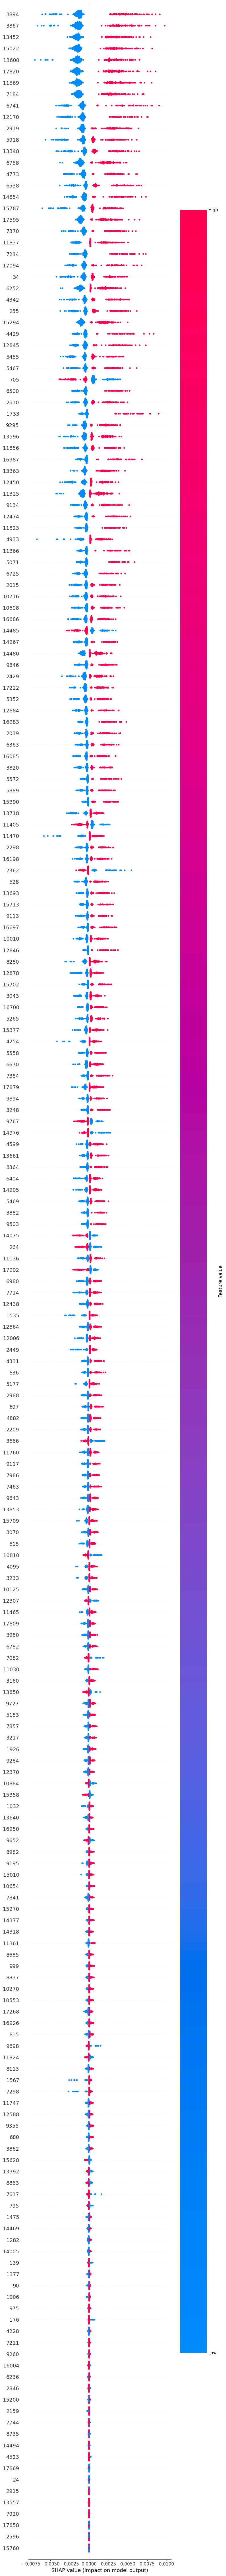

In [57]:
svn_shap = show_explainer_shap_importance(svm, X_test, X_train)

In [ ]:
svn_shap1 = show_kernel_explainer_shap_importance(_svm, X_test, X_train)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/234 [00:00<?, ?it/s]

In [17]:
X_train.sample(300)

,11837,15270,975,7211,17820,3160,999,10553,8837,10654,...,16697,11824,3217,14469,4331,3862,17869,14005,12370,17268
742,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
682,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
544,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
170,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
189,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
849,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [24]:
def get_important_by_threshold(df, threshold):
    percent = threshold * 0.01
    min = df.feature_importance_vals.min()
    max = df.feature_importance_vals.max()
    result = df[(df.feature_importance_vals - min) / max > percent].col_name.values
    print(f'the len of the result: {len(result)}')
    return result


def get_un_important_by_threshold(df, threshold):
    percent = threshold * 0.01
    min = df.feature_importance_vals.min()
    max = df.feature_importance_vals.max()
    print(f'min is {min}, max is {max}')
    result = df[(df.feature_importance_vals - min) / max <= percent].col_name.values
    print(f'the len of the result: {len(result)}')
    return result


def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
    result = a_set & b_set
    print(f'the common len result: {len(result)}')
    return result


features_to_delete = common_member(get_un_important_by_threshold(random_forest_shap, 15),
                                   get_un_important_by_threshold(svn_shap1, 15))
# features_to_delete = get_un_important_by_threshold(random_forest_shap, 15)
X_train_ad = X_train.drop(columns=features_to_delete)
X_test_ad = X_test.drop(columns=features_to_delete)

min is 2.0268657713344226e-05, max is 0.024884430288127198
the len of the result: 190
min is 4.832926581387445e-05, max is 0.09420265313565604
the len of the result: 95
the common len result: 91


              precision    recall  f1-score   support

       False       0.98      0.74      0.85       214
        True       0.24      0.85      0.37        20

    accuracy                           0.75       234
   macro avg       0.61      0.80      0.61       234
weighted avg       0.92      0.75      0.81       234



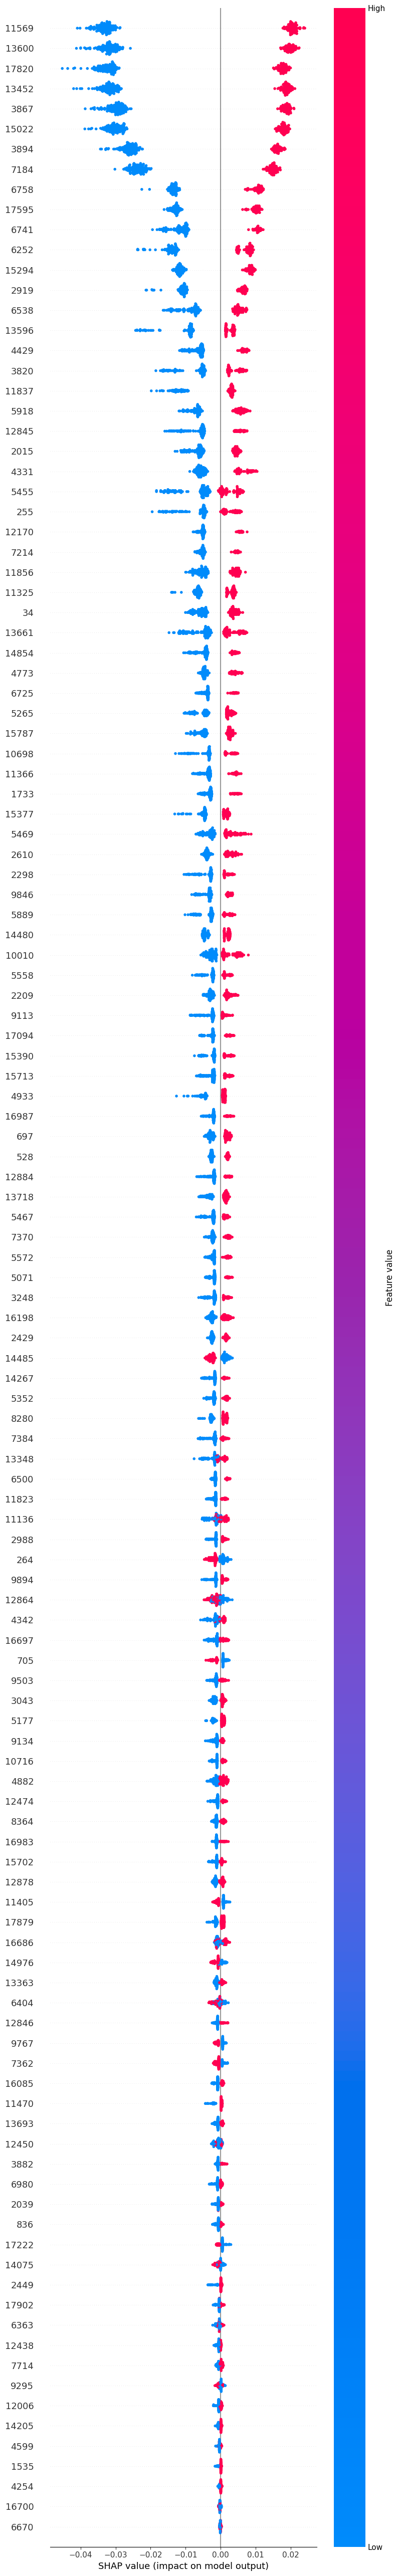

,col_name,feature_importance_vals
7,11569,0.028513
14,13600,0.027933
1,17820,0.027188
2,13452,0.027127
18,3867,0.026404
...,...,...
35,4599,0.000292
22,1535,0.000285
16,4254,0.000206
50,16700,0.000192


In [235]:
random_forest_ad = RandomForestClassifier(
    min_samples_leaf=17,
    class_weight='balanced_subsample',
    n_estimators=1000,
    criterion='gini',
    random_state=42)
random_forest_ad.fit(X_train_ad, y_train)

y_pred = random_forest_ad.predict(X_test_ad)
print(classification_report(y_test, y_pred))
show_tree_shap_importance(random_forest_ad, X_test_ad)

In [222]:
svm_ab = svm.SVC(kernel='rbf', class_weight='balanced', gamma=0.00001, probability=True, C=300)
svm_ab.fit(X_train_ad, y_train)

y_pred = svm_ab.predict(X_test_ad)
print(classification_report(y_test, y_pred))
#

              precision    recall  f1-score   support

       False       0.99      0.72      0.83       214
        True       0.23      0.90      0.37        20

    accuracy                           0.74       234
   macro avg       0.61      0.81      0.60       234
weighted avg       0.92      0.74      0.79       234



PermutationExplainer explainer: 235it [09:06,  2.36s/it]                         


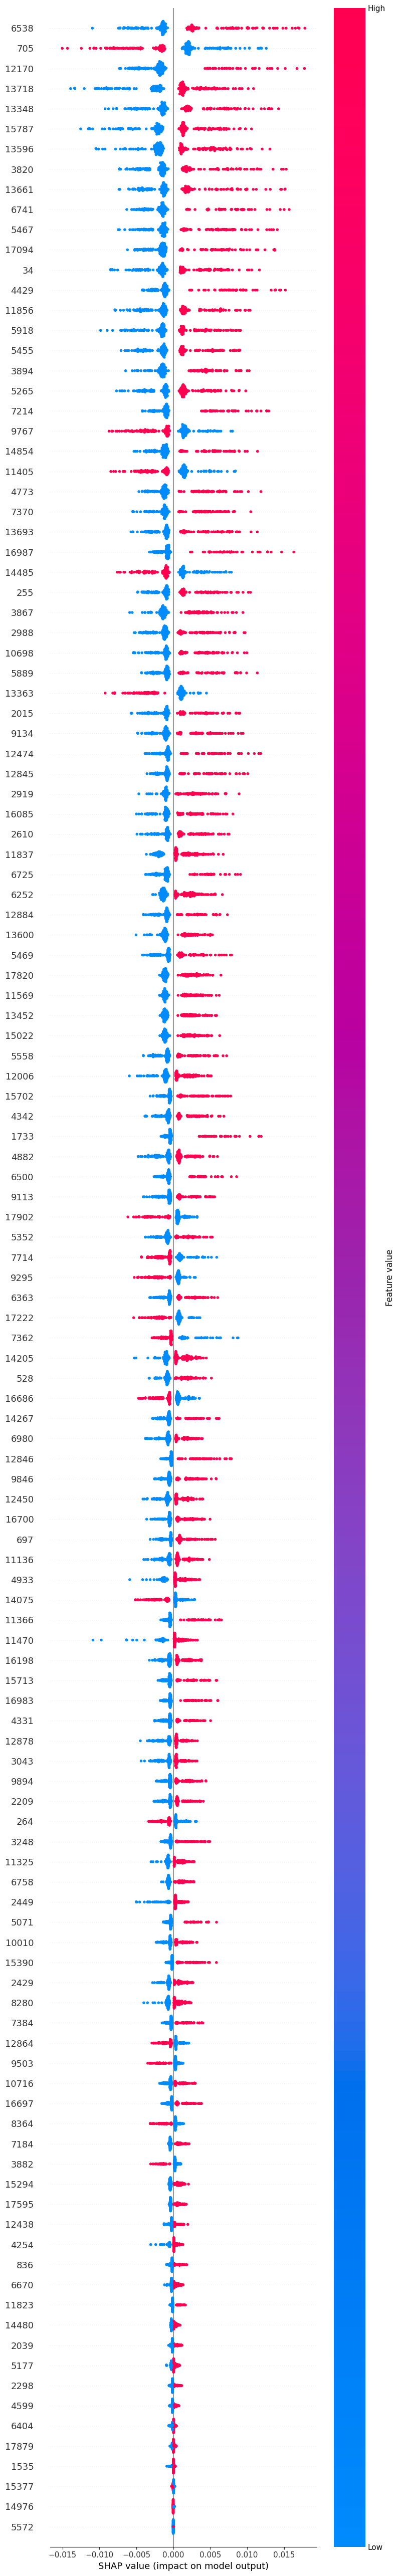

,col_name,feature_importance_vals
61,6538,0.004105
118,705,0.003924
110,12170,0.003511
70,13718,0.003510
64,13348,0.003442
...,...,...
9,17879,0.000133
22,1535,0.000121
20,15377,0.000064
74,14976,0.000030


In [226]:
show_explainer_shap_importance(svm_ab, X_test_ad, X_train_ad)

In [230]:
rus_classifier = RUSBoostClassifier(estimator=AdaBoostClassifier(), n_estimators=100, replacement=False,
                                    random_state=42)
rus_classifier.fit(X_train_ad, y_train)

y_pred = rus_classifier.predict(X_test_ad)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.77      0.86       214
        True       0.23      0.75      0.36        20

    accuracy                           0.77       234
   macro avg       0.60      0.76      0.61       234
weighted avg       0.91      0.77      0.82       234



In [231]:
easy_forest = EasyEnsembleClassifier(estimator=AdaBoostClassifier(), n_estimators=100, replacement=True,
                                     warm_start=True, n_jobs=-1,
                                     random_state=42)
easy_forest.fit(X_train_ad, y_train)
easy_forest.

y_pred = easy_forest.predict(X_test_ad)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.72      0.84       214
        True       0.24      0.95      0.39        20

    accuracy                           0.74       234
   macro avg       0.62      0.84      0.61       234
weighted avg       0.93      0.74      0.80       234



PermutationExplainer explainer: 235it [3:08:27, 48.32s/it]                           


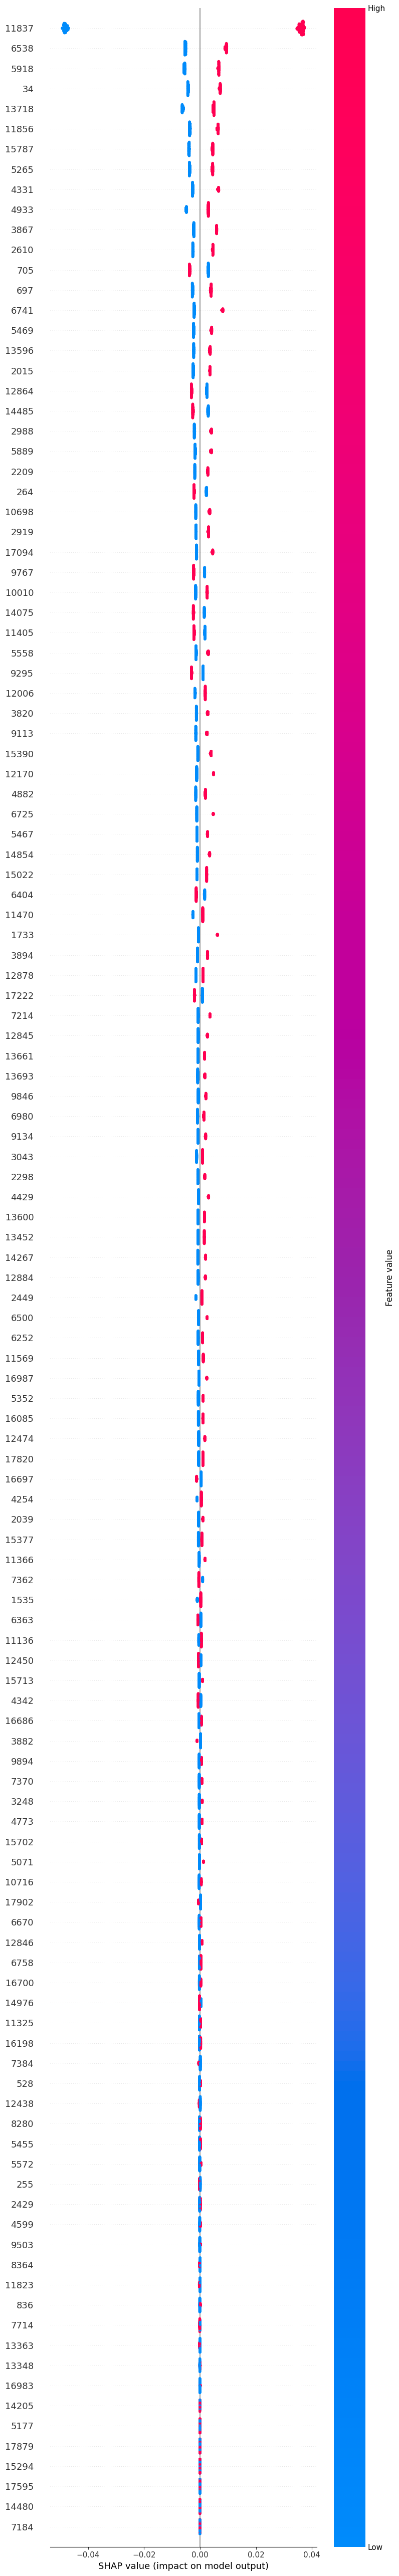

,col_name,feature_importance_vals
0,11837,0.040737
61,6538,0.006989
39,5918,0.006027
65,34,0.005477
70,13718,0.005434
...,...,...
13,5177,0.000000
8,15294,0.000000
5,17595,0.000000
10,7184,0.000000


In [234]:
show_explainer_shap_importance(easy_forest, X_test_ad, X_train_ad)

In [ ]:
show_tree_shap_importance()

In [225]:
xgb = XGBClassifier(scale_pos_weight=26, n_estimators=1000, n_jobs=-1)
xgb.fit(X_train_ad, y_train)

y_pred = xgb.predict(X_test_ad)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96       214
        True       0.58      0.35      0.44        20

    accuracy                           0.92       234
   macro avg       0.76      0.66      0.70       234
weighted avg       0.91      0.92      0.91       234



In [50]:
# from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
# from sklearn.svm import SVC
#
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid=param_grid, cv=cv, scoring='recall')
# grid.fit(X_train_nb, y_train_nb)
#
# print(
#     "The best parameters are %s with a score of %0.2f"
#     % (grid.best_params_, grid.best_score_)
# )
# from matplotlib import pyplot as plt
# from sklearn import svm
#
# svm = svm.SVC(kernel='rbf', class_weight='balanced', gamma=1e-09)
# svm.fit(X_train_nb, y_train_nb)
# from sklearn.metrics import classification_report
#
# y_pred = svm.predict(X_test_nb)
# print(classification_report(y_test_nb, y_pred))

The best parameters are {'C': 0.1, 'gamma': 1e-09} with a score of 1.00


In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# если выбирать больше признаков,
# то появляется ошибка
# https://stackoverflow.com/questions/49954406/logistic-regression-in-statsmodels-linalgerror-singular-matrix
# при применении logit ниже
rfe = RFE(model, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [470]:
after_rfe_x_ = X_train[X_train.columns[rfe.support_]]
after_rfe_test = X_test[X_test.columns[rfe.support_]]

In [471]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train, after_rfe_x_)
logit_resul = logit_model.fit()
print(logit_resul.summary2())

Optimization terminated successfully.
         Current function value: 0.165974
         Iterations 10
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.761     
Dependent Variable: is_depressed     AIC:              48.2155   
Date:               2023-11-27 23:08 BIC:              72.6420   
No. Observations:   85               Log-Likelihood:   -14.108   
Df Model:           9                LL-Null:          -58.912   
Df Residuals:       75               LLR p-value:      1.9515e-15
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
-------------------------------------------------------------------
         Coef.     Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
11837    -0.3026     2.1843   -0.1386   0.8898    -4.5838    3.9785
4933      1.0711     1.9383    0.5526   0.5805    -2.7278

In [472]:
import statsmodels.api as sm

after_rfe_x_1 = after_rfe_x_.drop(columns=['11837', '6538', '4933'])
logit_model = sm.Logit(y_train, after_rfe_x_1)
logit_resul = logit_model.fit()
print(logit_resul.summary2())

Optimization terminated successfully.
         Current function value: 0.172931
         Iterations 10
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.750     
Dependent Variable: is_depressed     AIC:              43.3983   
Date:               2023-11-27 23:09 BIC:              60.4968   
No. Observations:   85               Log-Likelihood:   -14.699   
Df Model:           6                LL-Null:          -58.912   
Df Residuals:       78               LLR p-value:      6.4336e-17
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
-------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025     0.975]
-------------------------------------------------------------------
2919      2.8310     1.6702    1.6950   0.0901    -0.4426    6.1046
15377     4.2523     1.8097    2.3497   0.0188     0.7053

In [473]:
after_rfe_test = after_rfe_test.drop(columns=['11837', '6538', '4933'])

<AxesSubplot:>

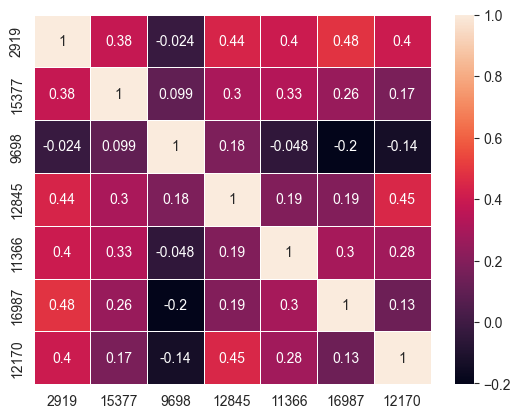

In [474]:
import seaborn as sns

sns.heatmap(after_rfe_x_1.corr(), annot=True, linewidth=.5)

In [340]:
after_rfe_test.columns

Index(['2919', '15377', '9698', '12845', '11366', '16987', '12170'], dtype='object')

In [475]:
test_samples_optimized = test_samples[after_rfe_test.columns].astype(float)

In [476]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(after_rfe_x_1, y_train)

LogisticRegression()

In [477]:
y_pred = logreg.predict(after_rfe_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(after_rfe_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


In [478]:
y_pred_2 = logreg.predict(test_samples_optimized)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(
    logreg.score(test_samples_optimized, y_test_samples)))

Accuracy of logistic regression classifier on test set: 0.85


In [ ]:
from sklearn.feature_selection import f_classif

X_data = data_frame.drop(columns=['is_depressed'])
y_data = data_frame['is_depressed']
f_value, p_statistic = f_classif(X_data, y_data)


In [ ]:
for feature in zip(data_frame.columns, f_value):
    print(feature)

In [44]:
from sklearn.feature_selection import mutual_info_classif

MI_score = mutual_info_classif(X_data, y_data, random_state=0)

# Print the name and mutual information score of each feature
# for feature in zip(data_frame.columns, MI_score):
#     print(feature.sort())


In [46]:
data_frame['is_depressed'].value_counts()

0    876
1     43
Name: is_depressed, dtype: int64

,human,is_depressed
0,D_Nov_A25_S86,True
1,D_Nov_A6_S48,True
6,D_Nov_A22_S50,True
44,D_Nov_A37_S93,True
58,D_Nov_A21_S39,True
60,D_Nov_A20_S92,True
61,D_Nov_A29_S40,True
66,D_Nov_A30_S51,True
80,D_Nov_A5_S37,True
83,D_Nov_A26_S7,True


In [45]:
sorted_by_second = sorted(list(zip(data_frame.columns, MI_score)), key=lambda tup: tup[1])
sorted_by_second

[('16212', 0.0),
 ('1967', 0.0),
 ('450', 0.0),
 ('10871', 0.0),
 ('17446', 0.0),
 ('1676', 0.0),
 ('13557', 0.0),
 ('1567', 0.0),
 ('7298', 0.0),
 ('7920', 0.0),
 ('10713', 0.0),
 ('1078', 0.0),
 ('2572', 0.0),
 ('9698', 0.0),
 ('176', 0.0),
 ('4523', 0.0),
 ('2449', 0.0),
 ('12006', 0.0),
 ('16004', 0.0),
 ('10810', 0.0),
 ('139', 0.0),
 ('1475', 0.0),
 ('7362', 0.0),
 ('5455', 0.0),
 ('7082', 0.0),
 ('6404', 0.0),
 ('11405', 0.0),
 ('9767', 0.0),
 ('4342', 0.0),
 ('15787', 0.0),
 ('16085', 0.0),
 ('3666', 0.0),
 ('13348', 0.0),
 ('34', 0.0),
 ('1032', 0.0),
 ('9643', 0.0),
 ('13718', 0.0),
 ('3820', 0.0),
 ('14976', 0.0),
 ('7384', 0.0),
 ('5265', 0.0),
 ('11030', 0.0),
 ('12864', 0.0),
 ('10125', 0.0),
 ('13661', 0.0),
 ('7857', 0.0),
 ('9355', 0.0),
 ('7986', 0.0),
 ('9284', 0.0),
 ('264', 0.0),
 ('9113', 0.0),
 ('14494', 0.0),
 ('15628', 0.0),
 ('3043', 0.0),
 ('17809', 0.0),
 ('10010', 0.0),
 ('12878', 0.0),
 ('14485', 0.0),
 ('10884', 0.0),
 ('4882', 0.0),
 ('12588', 0.0),
 ('1

## Описание API:
* _/human/_ - список всех субъектов, которые находятся в базе данных.
* _/human/{identifier}_ - комплексный отчет о субъекте с выбранным "идентификатором". Данные включают обработанные результаты анкетирования и информацию о мутации генов. (результаты тестов в формате questionnaire-result)
* _/human/{identifier}/files_ - доступные файлы ЭЭГ для выбранного субъекта.
* _/questionnaires/_ - список вопросников.
* _/questionnaires/{identifier}_ - информация о выбранной анкете {идентификатор}, включающая список вопросов.
* _/summaries/_ - список доступных результатов предметных анкет.
* _/summaries/{identifier}_ - список выбранных результатов значений опросника ({идентификатор}) для всех испытуемых.
* _/questionnaire-results/_ - список всех результатов анкет в базе данных.
* _/questionnaire-results/{identifier}_ - выбранные суммарные значения анкет с 'идентификатором'
* _/genes/_ - список генов в базе данных.
* _/genes/{identifier}_ - информация о выбранном гене со списком субъектов, имеющих мутации в данном гене.
* _/mutations/_ - список мутаций в базе данных.
* _/mutations/{identifier}_ - информация о выбранной мутации.
* _/files/_ - список файлов ЭЭГ в базе данных. Примеры: https://icbraindb.cytogen.ru/files/eeg/Yak_2016/D_Yak_2016_072/raw/D_Yak_2016_072_hunt.vmrk , https://icbraindb.cytogen.ru/files/eeg/Yak_2015/D_Yak_006/raw/D_Yak_006_Fon2.vmrk

In [ ]:
humansFrame = get_dataframe("/api-v2/mutations")
humansFrame

# заменить r_city на boolean "деревня?" и убрать доп поля на русском. Пол тоже можно заменить на bool "male?"

In [ ]:
get_dataframe("/api-v2/human")
# get_dataframe("/api-v2/human/D_Nov_002p_S1/mutations")

In [ ]:
get_dataframe("/api-v2/human/CO-У3-DUO-L28")

In [ ]:
for column in humansFrame.columns:
    if humansFrame[column].dtype == object:
        humansFrame[column] = update_to_nan(humansFrame[column])

Важное из комментов:
* CO-Y4-INS-002 коммент "панические атаки"
* CO-Y4-INS-023 коммент "тревожное расстройство"
* CO-Y5-MONO-04 коммент "эпилепсия"
* D_Nov_048_S89 коммент "компенсированный аутист"

Остальное либо дублирование id, например, для id D_Nov_025_S4 коммент D_Nov_025 (есть подозрение, что это для депрессивных),
либо дублирование национальности, например, для id Bai_2018_09 comment калмычка,черкес?

Скрипт для поиска по вхождениям: ```humansFrame[humansFrame.human.str.contains("(D_Nov_P_030.*)", regex=True)]```

In [ ]:
sickHumanList = (
    'D_Nov_P_001_1v', 'D_Nov_P_002_1v', 'D_Nov_P_003_1v', 'D_Nov_P_004_1v', 'D_Nov_P_005_1v', 'D_Nov_P_006_1v',
    'D_Nov_P_007_1v', 'D_Nov_P_008_1v', 'D_Nov_P_009_1v', 'D_Nov_P_009_2v', 'D_Nov_P_009_3v', 'D_Nov_P_010_1v',
    'D_Nov_P_011_1v', 'D_Nov_P_012_1v', 'D_Nov_P_013_1v', 'D_Nov_P_013_2v', 'D_Nov_P_014_1v', 'D_Nov_P_014_2v',
    'D_Nov_P_015_1v', 'D_Nov_P_015_2v', 'D_Nov_P_016_1v', 'D_Nov_P_017_1v', 'D_Nov_P_017_2v', 'D_Nov_P_018_1v',
    'D_Nov_P_018_2v', 'D_Nov_P_019_1v', 'D_Nov_P_019_2v', 'D_Nov_P_020_1v', 'D_Nov_P_020_2v', 'D_Nov_P_021_1v',
    'D_Nov_P_021_2v', 'D_Nov_P_022_1v', 'D_Nov_P_023_1v', 'D_Nov_P_023_2v', 'D_Nov_P_024_1v', 'D_Nov_P_024_2v',
    'D_Nov_P_025_1v', 'D_Nov_P_025_2v', 'D_Nov_P_026_1v', 'D_Nov_P_027_1v', 'D_Nov_P_027_2v', 'D_Nov_P_028_1v',
    'D_Nov_P_029_1v', 'D_Nov_P_029_2v', 'D_Nov_P_030_1v', 'D_Nov_P_030_2v', 'D_Nov_P_031_1v', 'D_Nov_P_031_2v',
    'D_Nov_P_032_1v', 'D_Nov_P_032_2v', 'D_Nov_P_033_1v', 'D_Nov_P_033_2v', 'D_Nov_P_034_1v', 'D_Nov_P_034_2v')
print('Size: ', len(sickHumanList))
sickHumans = humansFrame[(humansFrame.human.isin(sickHumanList))]
sickHumans

In [ ]:
sickHumans1 = humansFrame[humansFrame.r_city == 'депрессия']
sickHumans1

In [ ]:
def test_fill_empty():
    data = pd.read_csv("data/psychometria_depression.csv")
    dataColumns = data.columns
    humansColumns = humansFrame.columns.sort_values()
    humansColumns = humansColumns.drop(
        labels=["_url_files", "_url_mutations", "_url_self", "comments", "nationality", "nationality_en", "r_city",
                "r_country", "_url_files", "r_district", "ethnos"]).sort_values()
    dictionary = {'TA_score_testId=2': 'trait anxiety', 'Agr_testId=3': 'agr',
                  'Anger_testId=1': 'anger', 'BDI-sum_testId=18': 'bdi_sum',
                  'Cons_testId=3': 'cons', 'Extr_testId=3': 'Extr',
                  'Intel_testId=3': 'intel',
                  'Neur_testId=3': 'neur', 'age': 'age',
                  'atten_emot_EMIN_testId=8': 'att_emot_emin',
                  'des_emot_EMIN_testId=8': 'des_emot_emin', 'empaty_EMIN_testId=8': 'empathy_emin',
                  'hostil_testId=1': 'hostility', 'joy_emp_EMIN_testId=8': 'joy_emp_emin',
                  'miss_emp_EMIN_testId=8': 'mis_emp_emin',
                  'neg_expr_EMIN_testId=8': 'neg_expr_emin', 'physagr_testId=1': 'physag',
                  'pos_expr_EMIN_testId=8': 'pos_expr_emin', 'vebagr_testId=1': 'verbag'}
    #'bdi_16r', 'bdi_18r', , 'emot10', 'emot10_reappriasal', 'emot10_suppression', 'emot22_ruminat', 'WBSI_suppression'
    f = open("data/process_result.txt", "a")
    for human in data.CODE:
        humanRow = humansFrame[humansFrame.human == human]
        dataRow = data[data.CODE == human]
        for key in dictionary.keys():
            humanValue = humanRow.iloc[0][key]
            dataValue = dataRow.iloc[0][dictionary[key]]
            if dataValue == dataValue and humanValue != dataValue:
                f.write(
                    f"Для человека {human} значение теста {key} в базе {humanValue} не равно значению теста {dictionary[key]} в таблице {dataValue}\n\n")
    f.close()


def get_humans_excel():
    humans_excel = humansFrame.drop(columns=['_url_files', '_url_mutations', '_url_self', 'comments', 'nationality_en'])
    with pd.ExcelWriter('Missing_data.xlsx') as writer:
        summariesFrame.drop(
            columns=['_url_summariesByAlias', '_url_test', '_url_self', 'description_en', 'test_description_en',
                     'testname_en']).to_excel(writer, sheet_name='Опросники')
        humans_excel[humans_excel.r_city == 'депрессия'].to_excel(writer, sheet_name='Больные_депрессией')
        humans_excel[humans_excel.sex == 0].to_excel(writer, sheet_name='Отсутствует_много_данных')



In [ ]:
sickHumans = pd.read_csv('data/genetic codes.csv')

In [ ]:
def get_mutations(human):
    url = humansFrame[humansFrame['human'].str.contains(human)]['_url_mutations']
    if (url.empty):
        result = pd.DataFrame()
        result["message"] = [f"code {human} not found"]
        return result
    return get_dataframe(url.values[0])


with pd.ExcelWriter('mutations_for_sick_people.xlsx', engine='xlsxwriter') as writer:
    for code in sickHumans['код для секвенирования']:
        mutations = get_mutations(code)
        if 'message' in mutations:
            mutations.to_excel(writer, sheet_name=code)
        else:
            newDf = mutations.drop(columns=['_url_gene', '_url_human', '_url_self', 'human'])
            newDf.to_excel(writer, sheet_name=mutations.human.values[0])



In [ ]:
summariesFrame = get_dataframe("/api-v2/summaries")
summariesFrame

In [ ]:
def get_values_of_a_summary(summaries, alias):
    return summaries[summaries['alias'] == alias]._url_summariesByAlias.values[0]


for alias, test_id in zip(summariesFrame.alias, summariesFrame.test):
    try:
        valuesFrame = get_dataframe(get_values_of_a_summary(summariesFrame, alias))
        newColumnName = alias + "_testId=%s" % test_id
        valuesDictionary = dict(valuesFrame[['human', 'value']].values)
        humansFrame[newColumnName] = humansFrame.human.map(valuesDictionary)
    except:
        print("error in alias: %s" % alias)
humansFrame

In [ ]:
nulls = humansFrame.isna().sum().sort_values(ascending=False)
nulls

In [ ]:
clearedHumansFrame = humansFrame.copy()
for row_name in nulls.index:
    if (nulls[row_name] > 700):
        clearedHumansFrame.drop(columns=row_name, inplace=True)
clearedHumansFrame

In [ ]:
humansFrame[humansFrame.human == 'D_Nov_P_002']
# D_NOV -- человек из новосибирска, из болотного d_bol и тп. Можно как минимум заполнить r_city и district

In [ ]:
allFilledHumansFrame = clearedHumansFrame[~clearedHumansFrame.isnull().any(axis=1)]
allFilledHumansFrame

In [ ]:
def get_sequence(id, start, stop):
    record = get_gen_bank(id, start, stop)
    return record.seq


def get_gen_bank(id, start, stop):
    if os.path.exists(f"data/fasta/{id}_{start}_{stop}.fasta"):
        with open(f"data/fasta/{id}_{start}_{stop}.fasta") as handle:
            return SeqIO.read(handle, format="fasta")
    else:
        handle = Entrez.efetch(db="nuccore", id=id, rettype="fasta", retmode="text", seq_start=start,
                               seq_stop=stop,
                               complexity=1, strand=1)
        record = SeqIO.read(handle, "fasta")
        with open(f"data/fasta/{id}_{start}_{stop}.fasta", 'w+') as file:
            SeqIO.write(record, file, 'fasta')
        handle.close()
        return record


def get_gene_history(id):
    record = Entrez.read(Entrez.esummary(db='gene', id=id))
    return record['DocumentSummarySet']['DocumentSummary'][0]['LocationHist']


def get_history_item(history, position):
    for history_item in history:
        if int(history_item['ChrStart']) < position < int(history_item['ChrStop']) and history_item[
            "AnnotationRelease"] == "105.20220307":
            print(f'using item from history: AnnotationRelease = {history_item["AnnotationRelease"]}, '
                  f'AssemblyAccVer = {history_item["AssemblyAccVer"]}, '
                  f'ChrAccVer = {history_item["ChrAccVer"]}, '
                  f'ChrStart = {history_item["ChrStart"]}, '
                  f'ChrStop = {history_item["ChrStop"]}')
            return history_item
        if int(history_item['ChrStop']) < position < int(history_item['ChrStart']) and history_item[
            "AnnotationRelease"] == "105.20220307":
            print(f'using item from history: AnnotationRelease = {history_item["AnnotationRelease"]}, '
                  f'AssemblyAccVer = {history_item["AssemblyAccVer"]}, '
                  f'ChrAccVer = {history_item["ChrAccVer"]}, '
                  f'ChrStart = {history_item["ChrStart"]}, '
                  f'ChrStop = {history_item["ChrStop"]}')
            return history_item

ref_nucl parameter indicating reference locus variant;
type parameter indicating genotype (homozygote or heterozygote)

In [ ]:
class GeneMutationInfo:
    def __init__(self, gene_name, chromosome, mutations):
        self.gene_name = gene_name
        self.mutations = mutations
        self.chromosome = chromosome

    def __str__(self):
        return f'gene_name={self.gene_name}, \n'f'mutations={self.mutations}, \n'f'chromosome={self.chromosome}'


class MutationInfo:
    def __init__(self, mutation, position, ref_nucl, type):
        self.mutation = mutation
        self.position = position
        self.ref_nucl = ref_nucl
        self.type = type

    def __str__(self):
        return f'mutation={self.mutation}, \n'f'position={self.position}, \n'f'ref_nucl={self.ref_nucl}, \n'f'type={self.type}'


def change_indexes_to_relative(mutations, start):
    return dict(map(lambda x: ((x.position - start), x), mutations))


def convert_row_to_mutation_info(mutation, position, ref_nucl, type):
    return MutationInfo(mutation, position, ref_nucl, type)


def get_mutation_info(mutation_url):
    mutations = get_dataframe(mutation_url)
    mutations.drop(columns=['_url_self', '_url_gene', '_url_human', 'human', 'id'], inplace=True)
    gene_mutation_list = list()
    for index, item in (mutations.groupby(["gene", "chromosome"]).agg(list)).iterrows():
        mutation_info = list(map(convert_row_to_mutation_info, item.mutation, item.position, item.ref_nucl, item.type))
        gene_mutation_list.append(GeneMutationInfo(index[0], index[1], mutation_info))
    return gene_mutation_list


def create_new_sequence(sequence, mutations, start):
    dict = change_indexes_to_relative(mutations, start)
    target = ""
    seq_index = 0
    while seq_index <= (len(sequence) - 1):
        if seq_index in dict.keys():
            mutation = dict[seq_index]
            if mutation.ref_nucl.upper() != sequence[seq_index: seq_index + len(mutation.ref_nucl)]:
                raise ValueError(
                    f"value={sequence[seq_index: seq_index + len(mutation.ref_nucl)]} "
                    f"by index={seq_index} not equal "
                    f"to ref_nucl={mutation.ref_nucl} in mutation")
            target = target + mutation.mutation
            seq_index += len(mutation.ref_nucl)
        else:
            target = target + sequence[seq_index]
            seq_index += 1
    return target

In [ ]:
def add_gene_sequence_to_human(human):
    mutation_infos = get_mutation_info(human['_url_mutations'][1])
    for mutation_info in mutation_infos:
        try:
            history = get_history_item(get_gene_history(get_gene_id(mutation_info.gene_name)),
                                       mutation_info.mutations[0].position)
            history_start = int(history['ChrStart']) + 1
            history_stop = int(history['ChrStop']) + 1
            sequence = get_sequence(history['ChrAccVer'], history_start, history_stop)
            start = min(history_start, history_stop)
            sequence_with_mutations = create_new_sequence(sequence, mutation_info.mutations, start)
            human[mutation_info.gene_name] = sequence_with_mutations
        except Exception as ex:
            print(f"during handle mutation {mutation_info.gene_name} got exception {ex=}, {type(ex)=}")
            raise

In [ ]:
human = humansFrame[humansFrame['_url_mutations'] == "/api-v2/human/Co_y3_duo_EEG22/mutations"]
add_gene_sequence_to_human(human)
human

Результаты обработки:
during handle mutation APOC4 got exception ex=TypeError("'NoneType' object is not subscriptable"), type(ex)=<class 'TypeError'>
during handle mutation CKAP4 got exception ex=TypeError("'NoneType' object is not subscriptable"), type(ex)=<class 'TypeError'>
during handle mutation DNM1 got exception ex=TypeError("'NoneType' object is not subscriptable"), type(ex)=<class 'TypeError'>
during handle mutation DRD3 got exception ex=TypeError("'NoneType' object is not subscriptable"), type(ex)=<class 'TypeError'>
during handle mutation DRD4 got exception ex=TypeError("'NoneType' object is not subscriptable"), type(ex)=<class 'TypeError'>
during handle mutation HCRCR1 got exception ex=IndexError('list index out of range'), type(ex)=<class 'IndexError'> (ничего не нашлось, может имеется ввиду HCRTR1?)

In [ ]:
#!! в мутациях может быть всякая херня, например: cAAAaaaaaaaaaaaa,cAAaaaaaaaaaaaa,cAAAAaaaaaaaaaaaa (это три разных мутации?)... проверь чтобы не было лишних символов
history = get_history_item(get_gene_history(get_gene_id('ADRA2A')), 112839579)
history_start = int(history['ChrStart']) + 1
history_stop = int(history['ChrStop']) + 1
start = min(history_start, history_stop)
sequence = get_sequence(history['ChrAccVer'], history_start, history_stop)
our_index = 112839579 - start
print(our_index)
print(sequence[our_index - 5: our_index + 5])

In [ ]:
mutations = get_dataframe("/api-v2/human/Co_y3_duo_EEG22/mutations")
mutations

In [ ]:
questionnairesFrame = get_dataframe('/api-v2/questionnaires')
questionnairesFrame


In [ ]:
112836787 < 112839579 < 112840665

In [ ]:
questions3 = pd.json_normalize(get_dataframe("/api-v2/questionnaires/3").questions[0])
questions3